In [50]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

In [51]:
def fetch_data():
    df = pd.read_csv("./spy_data.csv")
    data = pd.DataFrame()

    data['Call Option Price'] = df[' [C_LAST]']
    data['Current Price'] = df[' [UNDERLYING_LAST]']
    data['Exercise Price'] = df[' [STRIKE]']
    data['Time to Expiration'] = df[' [DTE]']
    data['Volatility'] = df[' [C_IV]']

    # Fetch risk-free interest rate from yfinance
    df[' [QUOTE_DATE]'] = pd.to_datetime(df[' [QUOTE_DATE]'].str.strip(), format='%Y-%m-%d')
    data[' [QUOTE_DATE]'] = df[' [QUOTE_DATE]']
    risk_free_rate_df = yf.download('^IRX', start=df[' [QUOTE_DATE]'].min(), end=df[' [QUOTE_DATE]'].max())
    risk_free_rate_df['Risk-Free Interest Rate'] = risk_free_rate_df['Close'] / 100
    data = pd.merge(data, risk_free_rate_df[['Risk-Free Interest Rate']], left_on=' [QUOTE_DATE]', right_index=True, how='left')

    return data.drop(' [QUOTE_DATE]', axis=1)

data = fetch_data()
data = data[data.columns].apply(pd.to_numeric, errors='coerce')
data = data.dropna()
print(data)

/var/folders/y6/1d6nhf8n2hqfq_qz0hk_hpfr0000gn/T/ipykernel_91820/3395670119.py:2: DtypeWarning: Columns (8,9,10,11,12,13,15,17,18,20,21,23,24,25,26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./spy_data.csv")
[*********************100%%**********************]  1 of 1 completed


         Call Option Price  Current Price  Exercise Price  Time to Expiration   
78                    3.64         451.85           448.0                 0.0  \
82                    0.06         451.85           452.0                 0.0   
83                    0.01         451.85           453.0                 0.0   
84                    0.01         451.85           454.0                 0.0   
85                    0.01         451.85           455.0                 0.0   
...                    ...            ...             ...                 ...   
3589074               5.86         380.36           570.0              1022.0   
3589075               4.90         380.36           575.0              1022.0   
3589076               4.40         380.36           580.0              1022.0   
3589077               4.00         380.36           585.0              1022.0   
3589078               3.90         380.36           590.0              1022.0   

         Volatility  Risk-F

In [52]:
# Filter out rows where Time to Expiration or Volatility is zero because BSM assumes continous data
data = data[(data['Time to Expiration'] != 0) & (data['Volatility'] != 0)]

X = data.drop('Call Option Price', axis=1)
y = data['Call Option Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

       Call Option Price  Current Price  Exercise Price  Time to Expiration   
count       3.285314e+06   3.285314e+06    3.285314e+06        3.285314e+06  \
mean        2.977521e+01   3.860913e+02    3.732941e+02        1.634816e+02   
std         4.826811e+01   5.630006e+01    1.037407e+02        2.043854e+02   
min         0.000000e+00   2.222100e+02    5.000000e+00        1.000000e+00   
25%         4.000000e-02   3.407500e+02    3.060000e+02        2.200000e+01   
50%         7.000000e+00   3.927300e+02    3.730000e+02        7.800000e+01   
75%         3.935000e+01   4.337400e+02    4.400000e+02        2.329600e+02   
max         4.442000e+02   4.777700e+02    4.898000e+03        1.096000e+03   

         Volatility  Risk-Free Interest Rate  
count  3.285314e+06             3.285314e+06  
mean   3.310004e-01             7.204476e-03  
std    4.033717e-01             1.192128e-02  
min   -5.000000e-04            -1.050000e-03  
25%    1.809500e-01             4.300000e-04  
50%   

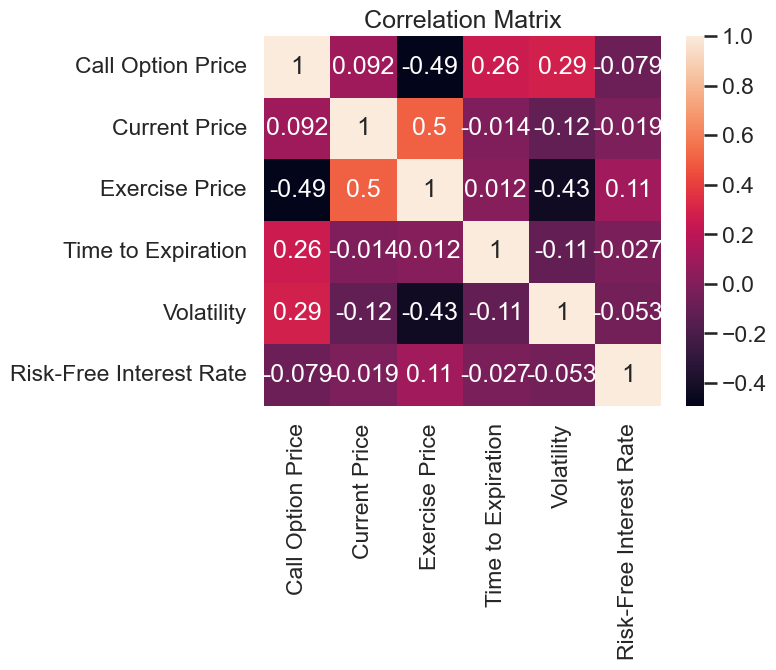

         VIF
0  27.167333
1  22.969824
2   1.624756
3   1.957348
4   1.378101


In [53]:
# Summary statistics
print(data.describe())

# Correlation matrix
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

# Check for collinearity
vif_data = pd.DataFrame() 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
print(vif_data)

In [54]:
vif_data["VIF"].mean()

11.019472304852755

In [55]:
data_sample = data.sample(n=1000, random_state=1)

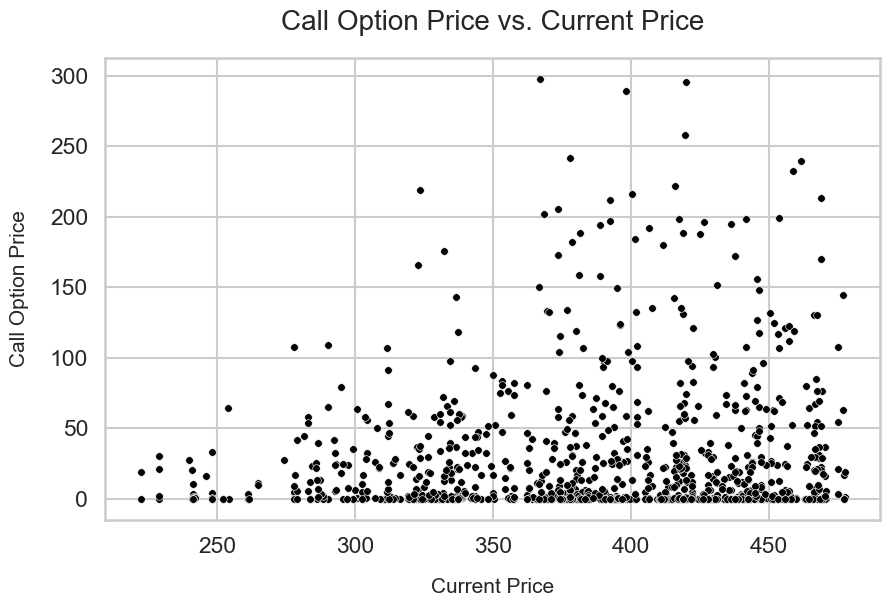

In [56]:
sns.set(style='whitegrid')
sns.set_context("talk")

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="Current Price", 
                     y="Call Option Price", 
                     data=data_sample, 
                     color='black', 
                     s=30)

ax.set_xlabel('Current Price', fontsize=15, labelpad=15)
ax.set_ylabel('Call Option Price', fontsize=15, labelpad=15)
ax.set_title('Call Option Price vs. Current Price', fontsize=20, pad=20)
plt.show()

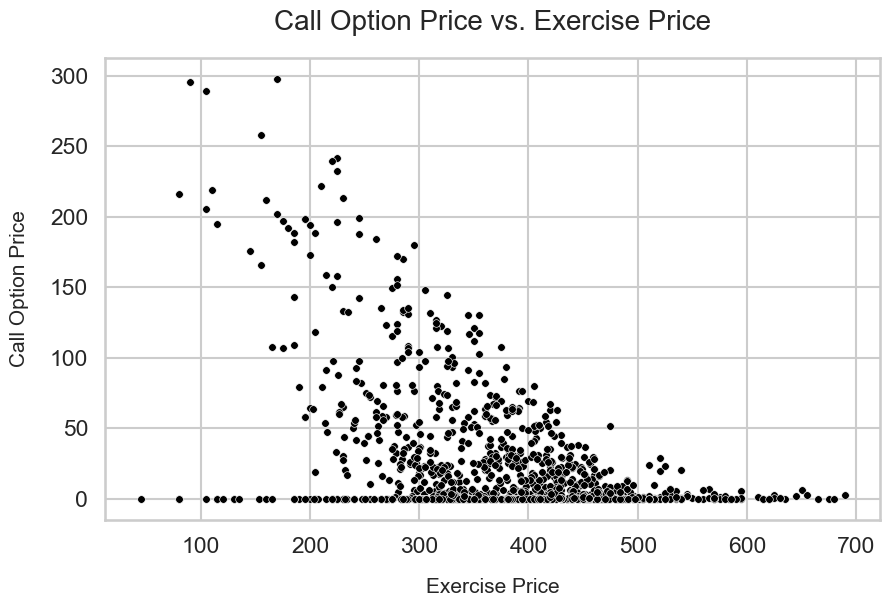

In [57]:
sns.set(style='whitegrid')
sns.set_context("talk")

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="Exercise Price", 
                     y="Call Option Price", 
                     data=data_sample, 
                     color='black', 
                     s=30)

ax.set_xlabel('Exercise Price', fontsize=15, labelpad=15)
ax.set_ylabel('Call Option Price', fontsize=15, labelpad=15)
ax.set_title('Call Option Price vs. Exercise Price', fontsize=20, pad=20)
plt.show()

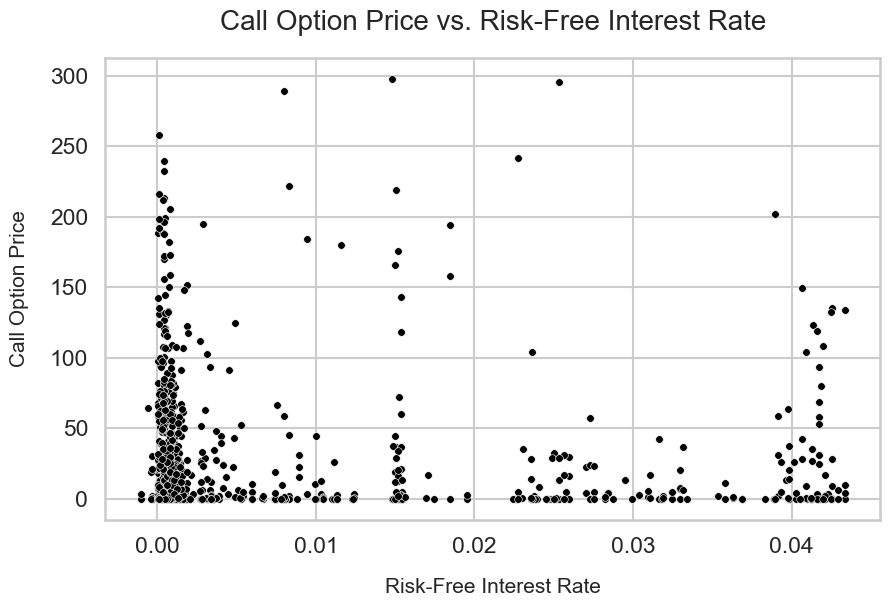

In [58]:
sns.set(style='whitegrid')
sns.set_context("talk")

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="Risk-Free Interest Rate", 
                     y="Call Option Price", 
                     data=data_sample, 
                     color='black', 
                     s=30)

ax.set_xlabel('Risk-Free Interest Rate', fontsize=15, labelpad=15)
ax.set_ylabel('Call Option Price', fontsize=15, labelpad=15)
ax.set_title('Call Option Price vs. Risk-Free Interest Rate', fontsize=20, pad=20)
plt.show()

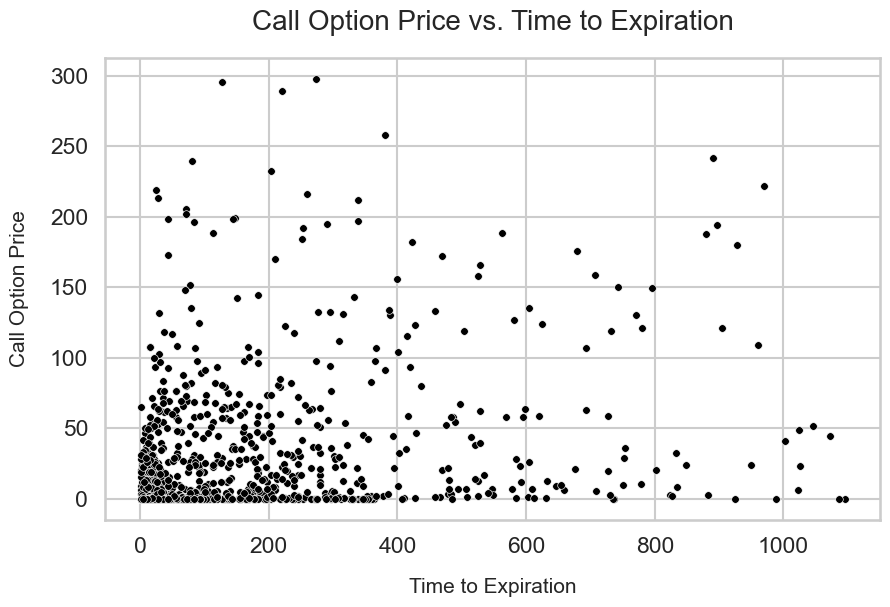

In [59]:
sns.set(style='whitegrid')
sns.set_context("talk")

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="Time to Expiration", 
                     y="Call Option Price", 
                     data=data_sample, 
                     color='black', 
                     s=30)

ax.set_xlabel('Time to Expiration', fontsize=15, labelpad=15)
ax.set_ylabel('Call Option Price', fontsize=15, labelpad=15)
ax.set_title('Call Option Price vs. Time to Expiration', fontsize=20, pad=20)
plt.show()

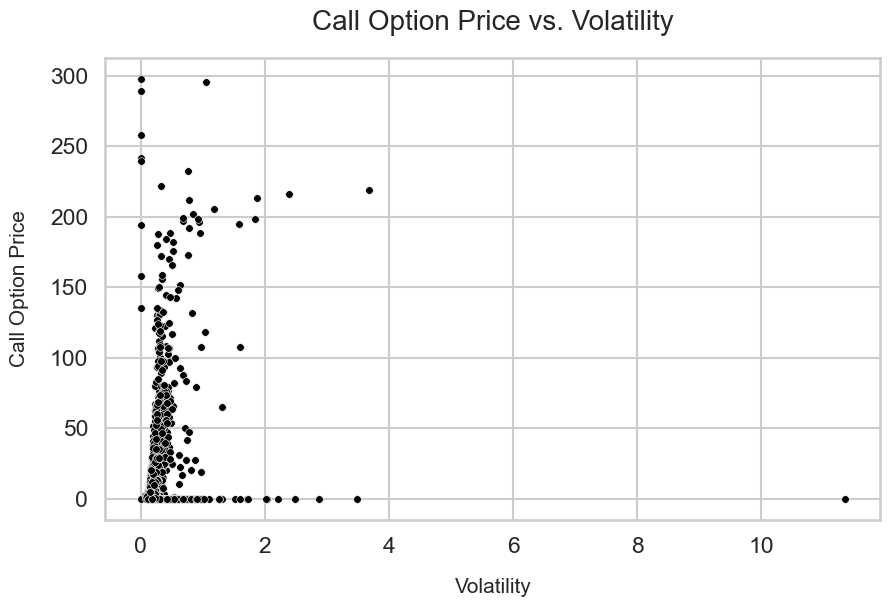

In [60]:
sns.set(style='whitegrid')
sns.set_context("talk")

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="Volatility", 
                     y="Call Option Price", 
                     data=data_sample, 
                     color='black', 
                     s=30)

ax.set_xlabel('Volatility', fontsize=15, labelpad=15)
ax.set_ylabel('Call Option Price', fontsize=15, labelpad=15)
ax.set_title('Call Option Price vs. Volatility', fontsize=20, pad=20)
plt.show()

In [61]:
# LASSO Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Features selected by LASSO
selected_features = X.columns[(lasso.coef_ != 0)]

In [62]:
selected_features

Index(['Current Price', 'Exercise Price', 'Time to Expiration', 'Volatility'], dtype='object')

In [63]:
# Linear Regression with all features
lr_all = LinearRegression()
lr_all.fit(X_train, y_train)
y_pred_all = lr_all.predict(X_test)

In [64]:
# Linear Regression with LASSO-selected features
lr_lasso = LinearRegression()
lr_lasso.fit(X_train[selected_features], y_train)
y_pred_lasso = lr_lasso.predict(X_test[selected_features])

In [65]:
# Black-Scholes-Merton Model
def black_scholes(row):
    S = row['Current Price']
    K = row['Exercise Price']
    T = row['Time to Expiration']
    r = row['Risk-Free Interest Rate']
    sigma = row['Volatility']

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

data['BSM Price'] = data.apply(black_scholes, axis=1)

In [66]:
print("RMSE of Linear Regression with all features: ", np.sqrt(mean_squared_error(y_test, y_pred_all)))
print("RMSE of Linear Regression with LASSO-selected features: ", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print("RMSE of Black-Scholes-Merton Model: ", np.sqrt(mean_squared_error(data['Call Option Price'], data['BSM Price'])))

RMSE of Linear Regression with all features:  35.01467859398997
RMSE of Linear Regression with LASSO-selected features:  35.02368984321055
RMSE of Black-Scholes-Merton Model:  265.3282875796633
